# Schumpeterian Economic Dynamics
 
In this Jupyter Notebook we explore parts of the paper _Schumpeterian economic dynamics as a quantifiable model of evolution_ by  [Stefan Thurner et al (2010 New J. Phys. 12 075029)](https://doi.org/10.1088/1367-2630/12/7/075029).

We simply seek to understand and implement the workings of creative destruction in a very simple economic perspective. 

In [1]:
import numpy as np
from scipy.special import binom
import matplotlib.pyplot as plt
import networkx as nx

from functools import partial

from typing import Optional
%matplotlib notebook

## Implementation details
The following functions define the generation of the product state vector $\sigma$ and rule tables $\alpha^\pm$. Further, we define how the diversity is calculated (a simple arithmetic mean of $\sigma$), as well as the positive and negative influences $\Delta_i$ on a product $i$. Lastly we are also in need of an update function, that determines the change of abundance of product $i$ depending on $\Delta_i$ and by a small chance on the parameter $p$. 

### Note
In the paper, the rule tabels $\alpha^\pm$ were described in a probabilistic way, such that:
$$
P(\alpha_{ijk} = 1) = r\cdot \binom{N}{2}^{-1}
$$
for parameters $r^\pm$, and $N$ being the total number of products. 

However, in testing this particular probabilistic definition, issues arose in reproducing the wanted figures. It seems that for small system sizes (as in our case with $N=100$ products) the statistical fluctuations do actually matter a lot, so it proved to be more sensible to exactly model the right number of incoming links in the productive and destructive sets.

In [39]:
def generate_sigma(N: int, p_init: int) -> np.ndarray:
    """Generate the initial sigma vector with random entries of 1 and 0."""
    p = np.zeros(N)
    p[:p_init] = np.ones(p_init)
    np.random.shuffle(p)
    return p


def generate_alpha(r: int, N: int) -> np.ndarray:
    """Generate the alpha tensor given a value for r such that:
        P(alpha_ijk = 1) = r/binom(N, 2)
    """
    p = r/binom(N, 2)  # probability alpha_ijk = 1
    return np.random.choice([0, 1], size=(N, N, N), p=[1-p, p])


def generate_exact_alpha(r: int, N: int) -> np.ndarray:
    """Generate the alpha tensor so that each node has exactly.
    
    Here we model an exact number of incoming destructive or productive links to a certain node.
    """
    a = np.zeros((N, N, N))
    for i in range(N):
        in_links = np.zeros(N**2)
        in_links[:r] = np.ones(r)
        np.random.shuffle(in_links)
        a[i] = in_links.reshape(N,N)
    
    return a
    

def diversity(sigma: np.ndarray, axis: Optional[int] = None) -> float:
    """Calculate the product diversity."""
    return np.mean(sigma, axis=axis)


def delta_i(sigma: np.ndarray, alpha_i: np.ndarray) -> float:
    """Calculate positive and negative influences on product i, such that:
        delta_i(sigma) = sum_{j,k} alpha_{i,j,k} * sigma_j * sigma_k
    with alpha = alpha_plus - alpha_minus.
    """
    # could also be np.einsum("jk,j,k", alpha_i, sigma, sigma)
    return sigma @ alpha_i @ sigma


def update_sigma_i(sigma: np.ndarray, i: int, delta_i: int, p: float) -> None:
    """Update the value of sigma at index i."""
    if delta_i > 0:
        sigma[i] = 1
    elif delta_i < 0:
        sigma[i] = 0
    
    roll = np.random.rand()
    if roll <= p:
        sigma[i] = 0 if sigma[i] == 1 else 0  # flip sigma[i]
        
    
def progress(current: int, total: int) -> str:
    """Create a string of shape [XXX    ] depicting progress."""
    return f"[{current*'X'}{(total-current)*' '}]"

## Setting inital and system defining parameters
and choosing the exact generation of the alpha rule tables over the probabilistic.

In [40]:
# Use the exact generation of the alpha rule tables
generate_alpha = generate_exact_alpha

# config parameters
pars = {
    "N": 100,       # number of different products
    "p_init": 20,   # number of initial products
    "r_plus": 10,   # parameter defining the nonzero entries in alpha_plus
    "r_minus": 15,  # parameter defining the nonzero entries in alpha_minus
    "p": 1e-4,      # probability to flip a product state
    "T": 4000       # number of timesteps
}

# update function parameters 
update_sigma_i = partial(update_sigma_i, p=pars['p'])

# set initial values
sigma = generate_sigma(pars["N"], pars["p_init"])
alpha_plus = generate_alpha(pars["r_plus"],  pars["N"])
alpha_minus = generate_alpha(pars["r_minus"], pars["N"])
alpha = alpha_plus - alpha_minus

### Sequential random update (in-place) + plots for product evolution over time & diversity over time

In [41]:
sigma_evolution = np.zeros((pars["T"]+1, pars["N"]))  # pre-alloc
indices = np.arange(pars["N"])
sigma_evolution[0] = sigma
show_progress_step = 10

print(progress(0, show_progress_step), end='\r')
lapcount = 0

for t in range(1, pars["T"] + 1):
    # print progress 
    if t%(pars['T']//show_progress_step) == 0: 
        lapcount += 1
        print(progress(lapcount, show_progress_step), end='\r')
    
    np.random.shuffle(indices)  # random order
    for i in indices:
        d_i = delta_i(sigma, alpha[i])
        update_sigma_i(sigma, i, d_i)
    
    sigma_evolution[t] = sigma  # track progress
     

<IPython.core.display.Javascript object>


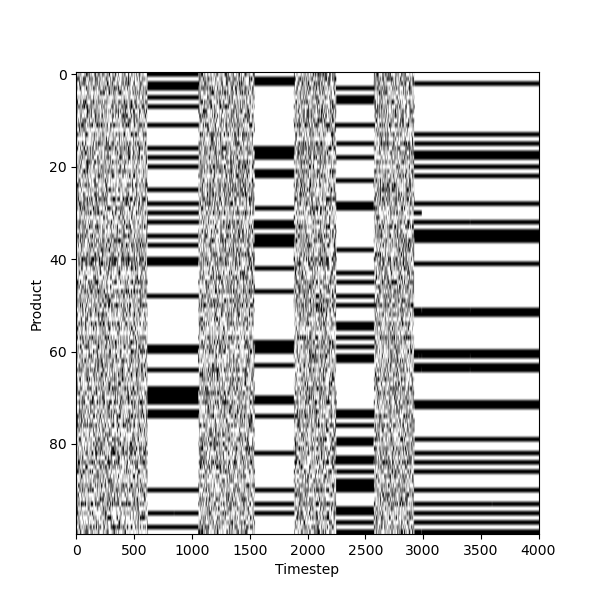

Text(0.5, 0, 'Timestep')

In [42]:
plt.figure(figsize=(6, 6))
plt.imshow(sigma_evolution.T, cmap='binary', aspect=pars['T']/pars['N'])
plt.ylabel("Product")
plt.xlabel("Timestep")
# plt.savefig("windows_in_noise_2.png", dpi=200)

<IPython.core.display.Javascript object>


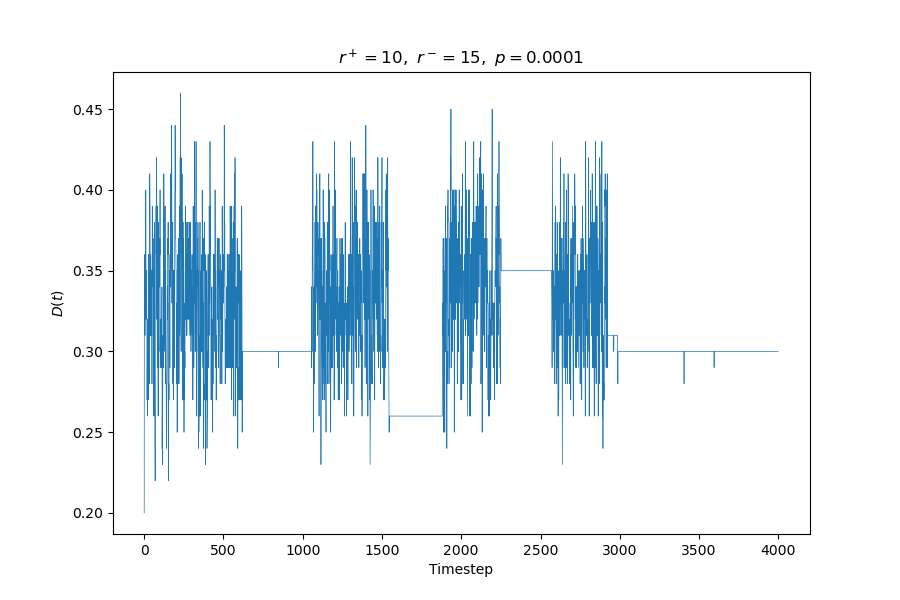

In [43]:
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111)
ax.plot(diversity(sigma_evolution, axis=1), linewidth=0.5)
ax.set_xlabel("Timestep")
ax.set_ylabel("$D(t)$")
ax.set_title(f"$r^+={pars['r_plus']},\ r^-={pars['r_minus']},\ p={pars['p']}$")
fig.savefig("diversity_smaller_p.png", dpi=200)